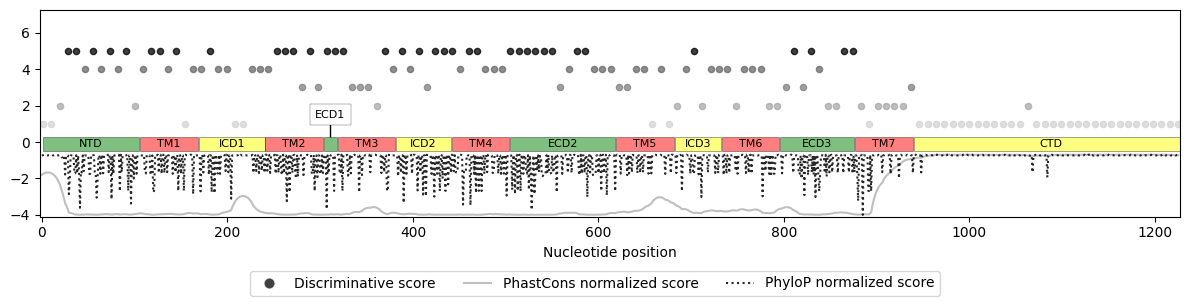

In [40]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as patches
from scipy.interpolate import interp1d

sys.path.append('utils')
import utils

# Single dataset definition
base_path = "data/"

def scale_to_range(data, new_min, new_max):
    old_min = np.min(data)
    old_max = np.max(data)
    return new_min + ((data - old_min) / (old_max - old_min)) * (new_max - new_min)

# Initialize the plot
fig, ax = plt.subplots(1, 1, figsize=(12, 3.5))

# Load and prepare data
scores = utils.load_data_from_json(f"{base_path}/results/UL33_categorized_scores.json")
position_to_key_map = {int(pos.split(',')[0][1:]): pos for pos in scores}
positions = sorted(position_to_key_map)
max_position = positions[-1]

# Plot individual scores
colors = ['lightgray', 'darkgrey', 'grey', 'dimgrey', 'black']
for pos in positions:
    f1_score = scores[position_to_key_map[pos]][3]
    ax.scatter(pos, f1_score, color=colors[int(f1_score) - 1], s=20, alpha=0.75)

# Load and interpolate conservation scores
phastCons_positions, phastCons_scores = utils.parse_wig(f"{base_path}/phastwebresult/phastConsscores.wig")
phyloP_positions, phyloP_scores = utils.parse_wig(f"{base_path}/phastwebresult/phyloPscores.wig")
phastCons_interpolator = interp1d(phastCons_positions, phastCons_scores, bounds_error=False, fill_value="extrapolate")
phyloP_interpolator = interp1d(phyloP_positions, phyloP_scores, bounds_error=False, fill_value="extrapolate")
interpolated_phastCons_scores = phastCons_interpolator(np.arange(max_position + 1))
interpolated_phyloP_scores = phyloP_interpolator(np.arange(max_position + 1))

# Scale scores and plot
scaled_phastCons_scores = scale_to_range(interpolated_phastCons_scores, -4, -0.7)
scaled_phyloP_scores = scale_to_range(interpolated_phyloP_scores, -4, -0.7)
ax.plot(np.arange(max_position + 1), scaled_phastCons_scores, label='PhastCons Scores', linestyle='-', color='grey', alpha=0.5)
ax.plot(np.arange(max_position + 1), scaled_phyloP_scores, label='PhyloP Scores', linestyle=':', color='black', alpha=0.85)

# Define and add regions
regions = [(1, 105, 'NTD'), (106, 168, 'TM1'), (169, 240, 'ICD1'), 
           (241, 303, 'TM2'), (304, 318, 'ECD1'), (319, 381, 'TM3'), 
           (382, 441, 'ICD2'), (442, 504, 'TM4'), (505, 618, 'ECD2'), 
           (619, 681, 'TM5'), (682, 732, 'ICD3'), (733, 795, 'TM6'), 
           (796, 876, 'ECD3'), (877, 939, 'TM7'), (940, 1236, 'CTD')]
for start, end, label in regions:
    color = 'red' if 'TM' in label else 'green' if 'NTD' in label or 'ECD' in label else 'yellow'
    rect = patches.Rectangle((start, -0.5), end - start, 0.8, linewidth=0.5, edgecolor='k', facecolor=color, alpha=0.5)
    ax.add_patch(rect)
    label_pos = 1.5 if label == 'ECD1' else -0.1
    if label == 'ECD1':
        ax.text((end - start) / 2 + start, label_pos, label, verticalalignment='center', horizontalalignment='center', color='black', fontsize=8, bbox=dict(facecolor='white', linewidth=0.2, alpha=1, edgecolor='black'))
        ax.vlines(x=(start + end) / 2, ymin=0.3, ymax=label_pos, colors='black', linewidth=1)
    else:
        ax.text((end - start) / 2 + start, label_pos, label, verticalalignment='center', horizontalalignment='center', color='black', fontsize=8)

# Set axis labels and limits
ax.set_xlabel('Nucleotide position')
ax.set_xlim(-2, max_position + 2)
ax.set_ylim(-4.1, 7.25)

# Create and add custom legend
custom_lines = [Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markersize=8, alpha=0.75),
                Line2D([0], [0], linestyle='-', color='grey', alpha=0.5),
                Line2D([0], [0], linestyle=':', color='black', alpha=0.85)]
fig.legend(custom_lines, ["Discriminative score", "PhastCons normalized score", "PhyloP normalized score"], loc='lower center', bbox_to_anchor=(0.5, 0.07), ncol=3)

# Adjust layout and save figure
plt.tight_layout(rect=[0, 0.15, 1, 0.95])
plt.savefig('fig/figure_discriminative_score_distribution.pdf', dpi=300)
plt.show()
